In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch


from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.networks.layers.factories import Act, Norm

from monai.config import print_config
from monai.metrics import DiceMetric
# from src.models.swincspunetr import SwinCSPUNETR
# from src.models.swincspunetr_unet import SwinCSPUNETR_unet
# from src.models.swincspunetr3plus import SwinCSPUNETR3plus

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\.conda\envs\UM\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.17.2
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.

In [2]:
# class_info = {
#     0: {"name": "background", "weight": 0},  # weight 없음
#     1: {"name": "apo-ferritin", "weight": 1000},
#     2: {"name": "beta-amylase", "weight": 100}, # 4130
#     3: {"name": "beta-galactosidase", "weight": 1500}, #3080
#     4: {"name": "ribosome", "weight": 1000},
#     5: {"name": "thyroglobulin", "weight": 1500},
#     6: {"name": "virus-like-particle", "weight": 1000},
# }

# # 가중치에 비례한 비율 계산
# raw_ratios = {
#     k: (v["weight"] if v["weight"] is not None else 0.01)  # 가중치 비례, None일 경우 기본값a
#     for k, v in class_info.items()
# }
# total = sum(raw_ratios.values())
# ratios = {k: v / total for k, v in raw_ratios.items()}

# # 최종 합계가 1인지 확인
# final_total = sum(ratios.values())
# print("클래스 비율:", ratios)
# print("최종 합계:", final_total)

# # 비율을 리스트로 변환
# ratios_list = [ratios[k] for k in sorted(ratios.keys())]
# print("클래스 비율 리스트:", ratios_list)

# 모델 설정

In [2]:
from src.dataset.dataset import create_dataloaders, create_dataloaders_bw
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd, RandCropByPosNegLabeld, RandCropd, RandSpatialCrop, RandGaussianSmoothd
)
from monai.transforms import CastToTyped
import numpy as np

train_img_dir = "./denoised_datasets/train/images"
train_label_dir = "./denoised_datasets/train/labels"
val_img_dir = "./denoised_datasets/val/images"
val_label_dir = "./denoised_datasets/val/labels"
# DATA CONFIG
img_size =  96 # Match your patch size
img_depth = img_size
n_classes = 1
batch_size = 16 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 1
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 10
# MODEL CONFIG
num_epochs = 4000
lamda = 0.5
ce_weight = 0.4
lr = 0.001
feature_size = 48
use_checkpoint = True
use_v2 = True
drop_rate= 0.2
attn_drop_rate = 0.2
num_bottleneck = 2
# CLASS_WEIGHTS
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치
sigma = 1.5
accumulation_steps = 1
# INIT
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
# )
])
# val_non_random_transforms = Compose([
#     EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
#     NormalizeIntensityd(keys=["image", "label"], nonzero=True, channel_wise=True),
#     Orientationd(keys=["image", "label"], axcodes="RAS"),
# ])
random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandGaussianSmoothd(
    keys=["image"],      # 변환을 적용할 키
    sigma_x = (0.5, sigma), # 각 축(x, y, z)의 시그마 값
    sigma_y = (0.5, sigma),
    sigma_z = (0.5, sigma),
    prob=0.5,
    )  
])
val_random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    # RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    # RandGaussianNoise(prob=0.5, mean=0.0, std=0.1),
])


In [3]:
train_loader, val_loader = None, None
train_loader, val_loader = create_dataloaders_bw(
    train_img_dir, 
    train_label_dir, 
    val_img_dir, 
    val_label_dir, 
    non_random_transforms = non_random_transforms, 
    val_non_random_transforms=non_random_transforms,
    random_transforms = random_transforms, 
    val_random_transforms=val_random_transforms,
    batch_size = loader_batch,
    num_workers=0,
    train_num_repeat=num_repeat,
    val_num_repeat=num_repeat,
    )

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


https://monai.io/model-zoo.html

In [4]:
from monai.losses import TverskyLoss
import torch
import torch.nn as nn

criterion = nn.MSELoss()  # 또는 nn.L1Loss()

In [5]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from pathlib import Path
from monai.networks.nets import UNet
from src.models import UNet_CBAM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=1,
    dropout = drop_rate,
    norm = Norm.INSTANCE,
    act = Act.PRELU 
).to(device)

pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"Denoising_UNET5_randnoise_{weight_str}_f{feature_size}_d{img_depth}s{img_size}_numb{num_bottleneck}_lr{lr:.0e}_a{lamda:.2f}_b{1-lamda:.2f}_b{batch_size}_r{num_repeat}_ce{ce_weight}_ac{accumulation_steps}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

기존 best model 발견: model_checkpoints\Denoising_UNET5_randnoise__f48_d96s96_numb2_lr1e-03_a0.50_b0.50_b16_r10_ce0.4_ac1\best_model.pt
기존 학습된 가중치를 성공적으로 로드했습니다.


C:\Users\pook0\AppData\Local\Temp\ipykernel_19372\916236007.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device

In [6]:
batch = next(iter(val_loader))
images, labels = batch["image"], batch["label"]
print(images.shape, labels.shape)

torch.Size([1, 1, 96, 96, 96]) torch.Size([1, 1, 96, 96, 96])


In [7]:
torch.backends.cudnn.benchmark = True

In [10]:
import wandb
from datetime import datetime

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = folder_name

# wandb 초기화
wandb.init(
    project='czii',  # 프로젝트 이름 설정
    name=run_name,         # 실행(run) 이름 설정
    config={
        'num_epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'lambda': lamda,
        # "cross_entropy_weight": ce_weight,
        'feature_size': feature_size,
        'img_size': img_size,
        # 'sampling_ratio': ratios_list,
        'device': device.type,
        "checkpoint_dir": str(checkpoint_dir),
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        # "use_checkpoint": use_checkpoint,
        "drop_rate": drop_rate,
        # "attn_drop_rate": attn_drop_rate,
        # "use_v2": use_v2,
        "accumulation_steps": accumulation_steps,
        "num_repeat": num_repeat,
        # "num_bottleneck": num_bottleneck,
        
        # 필요한 하이퍼파라미터 추가
    }
)
# 모델을 wandb에 연결
wandb.watch(model, log='all')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pook0612 (limbw). Use `wandb login --relogin` to force relogin


# 학습

In [11]:
# from monai.metrics import DiceMetric
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
    
def processing(batch_data, model, criterion, device):
    images = batch_data['image'].to(device)  # Input 이미지 (B, 1, 96, 96, 96)
    labels = batch_data['label'].to(device)  # 라벨 (B, 1, 96, 96, 96)
    
    # print("shape:", images.shape, labels.shape)

    labels = labels.float()  # 라벨을 float형으로 변환
    # print("shape:", images.shape, labels.shape)

    # 모델 예측
    outputs = model(images)  # outputs: (B, 1, 96, 96, 96)

    # Loss 계산
    loss = criterion(outputs, labels)
    return loss, outputs, labels

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, accumulation_steps=4):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # 그래디언트 초기화
    with tqdm(train_loader, desc='Training') as pbar:
        for i, batch_data in enumerate(pbar):
            # 손실 계산
            loss, _, _ = processing(batch_data, model, criterion, device)

            # 그래디언트를 계산하고 누적
            loss = loss / accumulation_steps  # 그래디언트 누적을 위한 스케일링
            loss.backward()  # 그래디언트 계산 및 누적
            
            # 그래디언트 업데이트 (accumulation_steps마다 한 번)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()  # 파라미터 업데이트
                optimizer.zero_grad()  # 누적된 그래디언트 초기화
            
            # 손실값 누적 (스케일링 복구)
            epoch_loss += loss.item() * accumulation_steps  # 실제 손실값 반영
            pbar.set_postfix(loss=loss.item() * accumulation_steps)  # 실제 손실값 출력
    avg_loss = epoch_loss / len(train_loader)
    wandb.log({'train_epoch_loss': avg_loss, 'epoch': epoch + 1})
    return avg_loss

# PSNR을 계산하는 함수
def calculate_psnr(pred, target):
    """
    PSNR을 계산하는 함수
    pred: 예측 이미지 (numpy 배열)
    target: 실제 이미지 (numpy 배열)
    """
    pred_np = pred.cpu().numpy()
    target_np = target.cpu().numpy()
    
    # 데이터 범위 확인
    data_range = target_np.max() - target_np.min()
    # print("Data range:", data_range)
    
    # NaN 또는 Inf 값 확인
    # print("NaN in pred:", np.isnan(pred_np).any())
    # print("NaN in target:", np.isnan(target_np).any())
    # print("Inf in pred:", np.isinf(pred_np).any())
    # print("Inf in target:", np.isinf(target_np).any())
    
    # MSE 값 확인
    mse_value = np.mean((target_np - pred_np) ** 2)
    # print("MSE:", mse_value)
    
    psnr_value = psnr(target_np, pred_np, data_range=data_range)
    
    return psnr_value

# 에포크별 검증 함수
def validate_one_epoch(model, val_loader, criterion, device, epoch, calculate_dice_interval):
    model.eval()
    val_loss = 0
    
    psnr_scores = []
    ssim_scores = []
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation') as pbar:
            for batch_data in pbar:
                loss, preds, labels = processing(batch_data, model, criterion, device)
                val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

                # PSNR, SSIM 계산
                if epoch % calculate_dice_interval == 0:
                    psnr_value = calculate_psnr(preds, labels)
                    
                    # PSNR, SSIM 값을 로깅
                    wandb.log({'psnr': psnr_value, 'epoch': epoch + 1})
                    # wandb.log({'ssim': ssim_value, 'epoch': epoch + 1})
                    print(f"PSNR: {psnr_value:.4f},", end=", ")
                    
                    psnr_scores.append(psnr_value)
                    # ssim_scores.append(ssim_value)

    avg_loss = val_loss / len(val_loader)
    # 에포크별 평균 손실 로깅
    wandb.log({'val_epoch_loss': avg_loss, 'epoch': epoch + 1})
    
    if epoch % calculate_dice_interval == 0:
        print("Validation PSNR and SSIM Scores")
        overall_mean_psnr = np.mean(psnr_scores)
        # overall_mean_ssim = np.mean(ssim_scores)
        wandb.log({'overall_mean_psnr': overall_mean_psnr, 'epoch': epoch + 1})
        print(f"\nOverall Mean PSNR: {overall_mean_psnr:.4f}\n")

    # if overall_mean_fbeta is None:
    #     overall_mean_fbeta = 0

    # 시각화 코드
    # 예측과 라벨을 시각화
    
    # preds = preds.cpu().numpy()
    # labels = labels.cpu().numpy()
    # preds = np.squeeze(preds, axis=0)
    # preds = np.squeeze(preds, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # labels = np.squeeze(labels, axis=0)
    # # print(preds.shape, labels.shape)
    
    # slice_idx = 50
    # plt.figure(figsize=(10, 5))

    # # Image 1 비교
    # plt.subplot(1, 2, 1)
    # plt.imshow(preds[slice_idx], cmap="gray")
    # plt.title("Image: Original")
    # plt.axis("off")

    # plt.subplot(1, 2, 2)
    # plt.imshow(labels[slice_idx], cmap="gray")
    # plt.title("Label: denoised")
    # plt.axis("off")
    # plt.show()
    
    return val_loss / len(val_loader), overall_mean_psnr

def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, 
    device, start_epoch, best_val_loss, best_val_fbeta_score=0, calculate_dice_interval=1,
    accumulation_steps=4
):
    """
    모델을 학습하고 검증하는 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 총 학습 epoch 수
        patience: early stopping 기준
        device: GPU/CPU 장치
        start_epoch: 시작 epoch
        best_val_loss: 이전 최적 validation loss
        best_val_fbeta_score: 이전 최적 validation f-beta score
        calculate_dice_interval: Dice 점수 계산 주기
    """
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train One Epoch
        train_loss = train_one_epoch(
            model=model, 
            train_loader=train_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            device=device,
            epoch=epoch,
            accumulation_steps= accumulation_steps
        )
        
        scheduler.step(train_loss)
        # Validate One Epoch
        val_loss, overall_mean_psnr = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=epoch, 
            calculate_dice_interval=calculate_dice_interval
        )

        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation PSNR: {overall_mean_psnr:.4f}")

        if val_loss < best_val_loss and overall_mean_psnr > best_val_fbeta_score:
            best_val_loss = val_loss
            best_val_fbeta_score = overall_mean_psnr
            epochs_no_improve = 0
            checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            print(f"========================================================")
            print(f"SUPER Best model saved. Loss:{best_val_loss:.4f}, Score:{best_val_fbeta_score:.4f}")
            print(f"========================================================")

        # Early stopping 조건 체크
        if val_loss >= best_val_loss and overall_mean_psnr <= best_val_fbeta_score:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        if epochs_no_improve >= patience:
            print("Early stopping")
            checkpoint_path = os.path.join(checkpoint_dir, 'last.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            break
        # if epochs_no_improve%6 == 0 & epochs_no_improve != 0:
        #     # 손실이 개선되지 않았으므로 lambda 감소
        #     new_lamda = max(criterion.lamda - 0.01, 0.35)  # 최소값은 0.1로 설정
        #     criterion.set_lamda(new_lamda)
        #     print(f"Validation loss did not improve. Reducing lambda to {new_lamda:.4f}")

    wandb.finish()


In [12]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=5,
    device=device,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss,
    best_val_fbeta_score=best_val_fbeta_score,
    calculate_dice_interval=1,
    accumulation_steps = accumulation_steps
     ) 

Epoch 1/4000


Validation:  20%|██        | 2/10 [00:00<00:00, 17.89it/s, loss=0.184]

PSNR: 29.4257,, PSNR: 29.3400,, PSNR: 28.5205,, PSNR: 29.0496,, 

Validation:  80%|████████  | 8/10 [00:00<00:00, 19.71it/s, loss=0.203]

PSNR: 28.0266,, PSNR: 26.5100,, PSNR: 29.4470,, PSNR: 29.0390,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 19.78it/s, loss=0.397]


PSNR: 28.6225,, PSNR: 27.1061,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 28.5087

Training Loss: 0.6079, Validation Loss: 0.2623, Validation PSNR: 28.5087
SUPER Best model saved. Loss:0.2623, Score:28.5087
Epoch 2/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 22.55it/s, loss=0.184]

PSNR: 29.6233,, PSNR: 31.4873,, PSNR: 29.9634,, PSNR: 31.4228,, PSNR: 29.6036,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.12it/s, loss=0.207]


PSNR: 31.0024,, PSNR: 26.1910,, PSNR: 30.3244,, PSNR: 28.8199,, PSNR: 30.5357,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 29.8974

Training Loss: 0.3165, Validation Loss: 0.2152, Validation PSNR: 29.8974
SUPER Best model saved. Loss:0.2152, Score:29.8974
Epoch 3/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.38it/s, loss=0.182]

PSNR: 30.0998,, PSNR: 25.2514,, PSNR: 31.7713,, PSNR: 31.7662,, PSNR: 29.5639,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.63it/s, loss=0.136]


PSNR: 31.2592,, PSNR: 32.1660,, PSNR: 31.0665,, PSNR: 32.5312,, PSNR: 30.7358,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 30.6211

Training Loss: 0.2782, Validation Loss: 0.1753, Validation PSNR: 30.6211
SUPER Best model saved. Loss:0.1753, Score:30.6211
Epoch 4/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.25it/s, loss=0.201] 

PSNR: 33.1885,, PSNR: 32.4860,, PSNR: 31.6228,, PSNR: 32.7718,, PSNR: 29.8797,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.52it/s, loss=0.0889]

PSNR: 30.3614,, PSNR: 30.8223,, PSNR: 32.7439,, PSNR: 31.9867,, PSNR: 33.4720,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.9335

Training Loss: 0.2469, Validation Loss: 0.1127, Validation PSNR: 31.9335


SUPER Best model saved. Loss:0.1127, Score:31.9335
Epoch 5/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 23.96it/s, loss=0.0768]

PSNR: 27.6777,, PSNR: 33.0098,, PSNR: 33.4008,, PSNR: 33.3030,, PSNR: 33.1620,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.54it/s, loss=0.0961]


PSNR: 26.9461,, PSNR: 31.9914,, PSNR: 31.6859,, PSNR: 31.6343,, PSNR: 31.3861,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.4197

Training Loss: 0.2338, Validation Loss: 0.1335, Validation PSNR: 31.4197
Epoch 6/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.08it/s, loss=0.113] 

PSNR: 31.2903,, PSNR: 30.4818,, PSNR: 34.4425,, PSNR: 32.5745,, PSNR: 32.1613,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.62it/s, loss=0.167]


PSNR: 32.1184,, PSNR: 28.9460,, PSNR: 32.7959,, PSNR: 31.0012,, PSNR: 29.8684,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.5680

Training Loss: 0.2285, Validation Loss: 0.1334, Validation PSNR: 31.5680
Epoch 7/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.07it/s, loss=0.155]

PSNR: 32.5694,, PSNR: 29.7800,, PSNR: 29.1798,, PSNR: 30.2891,, PSNR: 31.8043,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.53it/s, loss=0.105]


PSNR: 31.7371,, PSNR: 33.4753,, PSNR: 29.8120,, PSNR: 31.5899,, PSNR: 33.3921,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.3629

Training Loss: 0.2041, Validation Loss: 0.1355, Validation PSNR: 31.3629
Epoch 8/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 23.16it/s, loss=0.124]

PSNR: 32.0703,, PSNR: 32.6977,, PSNR: 31.0575,, PSNR: 33.2023,, 

Validation:  90%|█████████ | 9/10 [00:00<00:00, 22.65it/s, loss=0.106] 

PSNR: 33.6220,, PSNR: 33.1544,, PSNR: 33.3600,, PSNR: 32.1442,, PSNR: 32.4964,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 22.38it/s, loss=0.181]


PSNR: 29.6262,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.3431

Training Loss: 0.2609, Validation Loss: 0.1143, Validation PSNR: 32.3431
Epoch 9/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.08it/s, loss=0.0937]

PSNR: 30.3701,, PSNR: 28.5016,, PSNR: 33.3406,, PSNR: 33.7521,, PSNR: 31.7534,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.77it/s, loss=0.315]


PSNR: 33.7500,, PSNR: 32.9730,, PSNR: 27.8692,, PSNR: 30.2021,, PSNR: 28.4370,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.0949

Training Loss: 0.2180, Validation Loss: 0.1529, Validation PSNR: 31.0949
Epoch 10/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.66it/s, loss=0.468]

PSNR: 31.0873,, PSNR: 31.1472,, PSNR: 27.6826,, PSNR: 30.9202,, PSNR: 27.2268,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 24.61it/s, loss=0.184]


PSNR: 30.3814,, PSNR: 32.0080,, PSNR: 27.9767,, PSNR: 26.4541,, PSNR: 29.6832,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 29.4567

Training Loss: 0.2544, Validation Loss: 0.2175, Validation PSNR: 29.4567
Epoch 11/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.28it/s, loss=0.115] 

PSNR: 31.7132,, PSNR: 31.4292,, PSNR: 33.2607,, PSNR: 33.6320,, PSNR: 33.7020,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.60it/s, loss=0.187]


PSNR: 30.4913,, PSNR: 30.2240,, PSNR: 29.6648,, PSNR: 30.7910,, PSNR: 28.7963,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.3704

Training Loss: 0.2669, Validation Loss: 0.1248, Validation PSNR: 31.3704
Epoch 12/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.63it/s, loss=0.0827]

PSNR: 34.3649,, PSNR: 30.5307,, PSNR: 33.0272,, PSNR: 28.9530,, PSNR: 33.4390,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 24.27it/s, loss=0.0979]


PSNR: 31.9402,, PSNR: 32.7064,, PSNR: 25.6697,, PSNR: 32.9921,, PSNR: 32.7923,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.6415

Training Loss: 0.1840, Validation Loss: 0.1457, Validation PSNR: 31.6415
Epoch 13/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.22it/s, loss=0.0902]

PSNR: 33.5325,, PSNR: 34.6749,, PSNR: 35.2860,, PSNR: 31.3162,, PSNR: 31.4874,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 24.53it/s, loss=0.0677]


PSNR: 33.0160,, PSNR: 31.7505,, PSNR: 34.0723,, PSNR: 33.5432,, PSNR: 33.0647,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 33.1744

Training Loss: 0.1867, Validation Loss: 0.0928, Validation PSNR: 33.1744
SUPER Best model saved. Loss:0.0928, Score:33.1744
Epoch 14/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 23.92it/s, loss=0.0786]

PSNR: 32.7215,, PSNR: 33.2273,, PSNR: 31.7913,, PSNR: 32.1024,, PSNR: 33.8363,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.49it/s, loss=0.144]


PSNR: 28.3299,, PSNR: 32.8384,, PSNR: 30.5241,, PSNR: 30.7534,, PSNR: 30.3947,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.6519

Training Loss: 0.1633, Validation Loss: 0.1220, Validation PSNR: 31.6519
Epoch 15/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 23.80it/s, loss=0.0947]

PSNR: 34.2802,, PSNR: 32.8053,, PSNR: 35.0297,, PSNR: 32.0370,, PSNR: 31.6080,, 

Validation:  90%|█████████ | 9/10 [00:00<00:00, 20.22it/s, loss=0.148] 

PSNR: 30.1913,, PSNR: 33.5328,, PSNR: 32.5443,, PSNR: 32.4057,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 21.08it/s, loss=0.148]


PSNR: 31.6704,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 32.6105

Training Loss: 0.1658, Validation Loss: 0.1060, Validation PSNR: 32.6105
Epoch 16/4000


Validation:  20%|██        | 2/10 [00:00<00:00, 19.44it/s, loss=0.159]

PSNR: 27.6809,, PSNR: 31.9210,, PSNR: 31.1375,, PSNR: 31.2113,, 

Validation:  80%|████████  | 8/10 [00:00<00:00, 21.07it/s, loss=0.187]

PSNR: 28.5253,, PSNR: 28.4532,, PSNR: 28.1039,, PSNR: 29.0800,, PSNR: 32.8784,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 21.11it/s, loss=0.187]


PSNR: 28.5937,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 29.7585

Training Loss: 0.2338, Validation Loss: 0.2025, Validation PSNR: 29.7585
Epoch 17/4000


Validation:  30%|███       | 3/10 [00:00<00:00, 24.05it/s, loss=0.0882]

PSNR: 32.2566,, PSNR: 32.8546,, PSNR: 31.3211,, PSNR: 32.4496,, PSNR: 32.5610,, 

Validation: 100%|██████████| 10/10 [00:00<00:00, 23.61it/s, loss=0.175]


PSNR: 32.0775,, PSNR: 33.2222,, PSNR: 32.6579,, PSNR: 31.5577,, PSNR: 28.8968,, Validation PSNR and SSIM Scores

Overall Mean PSNR: 31.9855

Training Loss: 0.2223, Validation Loss: 0.1055, Validation PSNR: 31.9855
Early stopping


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
overall_mean_psnr,▁▃▄▆▅▆▅▇▅▂▅▆█▆▇▃▆
psnr,▂▄▄▅▂▁▆▆▃▇▆█▆▄▅▇▇▇▄▃▇▇▅▇▅█▅▄▇▇▇▆▃▅█▆▄▇▆▇
train_epoch_loss,█▃▃▂▂▂▂▃▂▂▃▁▁▁▁▂▂
val_epoch_loss,█▆▄▂▃▃▃▂▃▆▂▃▁▂▂▆▂
epoch,17
overall_mean_psnr,31.98548
psnr,28.89678
train_epoch_loss,0.22228
val_epoch_loss,0.1055


기존 best model 발견: model_checkpoints\Denoising_UNET5_randnoise__f48_d96s96_numb2_lr1e-03_a0.50_b0.50_b16_r10_ce0.4_ac1\best_model.pt


C:\Users\pook0\AppData\Local\Temp\ipykernel_19372\2734822490.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=devic

기존 학습된 가중치를 성공적으로 로드했습니다.


Visualizing:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]


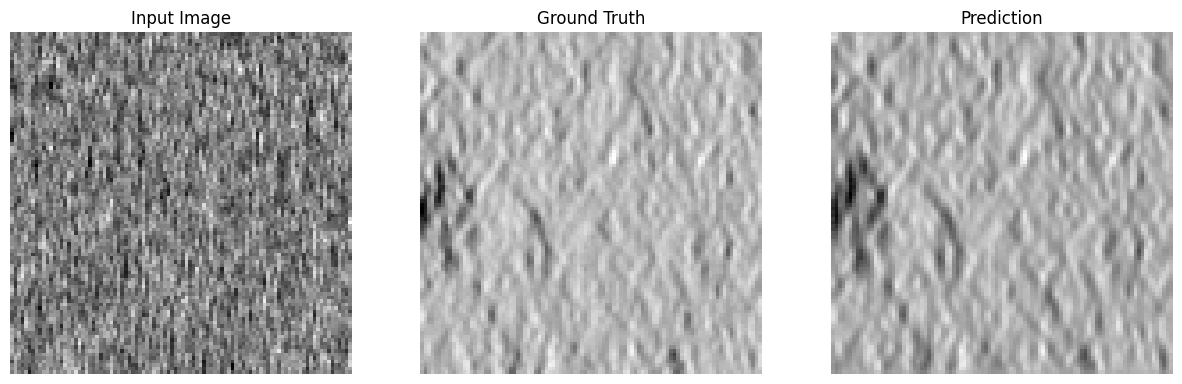

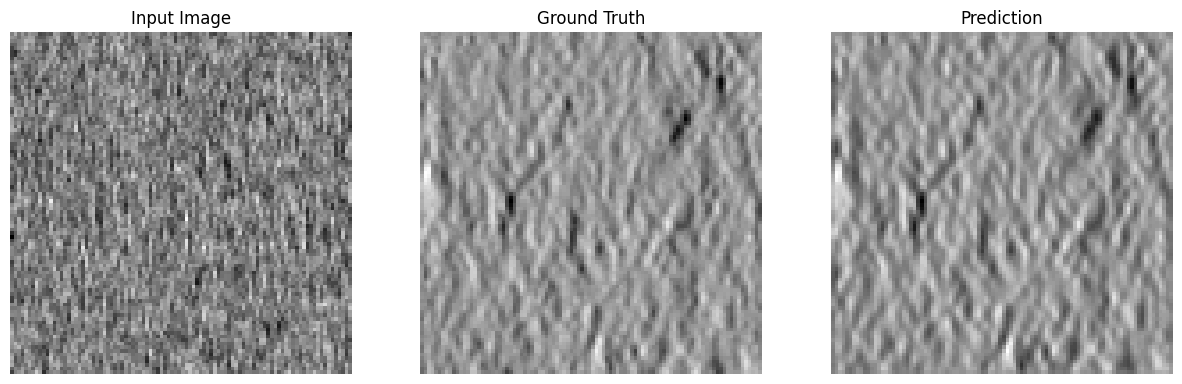

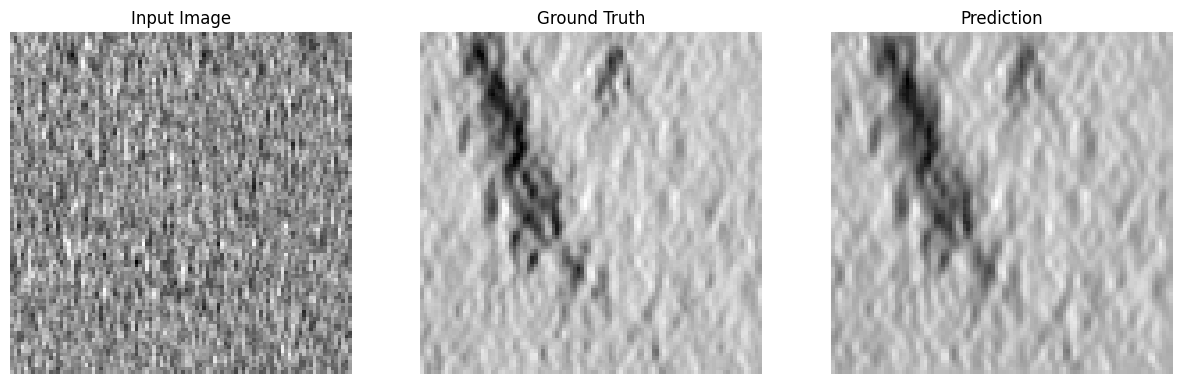

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 최적의 모델 불러오기
def load_best_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def get_predictions(model, data_loader, device, num_images=5):
    model.eval()
    images, labels, preds = [], [], []
    
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc='Visualizing'):
            image = batch_data['image'].to(device)
            label = batch_data['label'].to(device)
            
            pred = model(image)
            
            images.append(image.cpu().numpy())
            labels.append(label.cpu().numpy())
            preds.append(pred.cpu().numpy())
            
            if len(images) >= num_images:
                break
    return images, labels, preds
# 예측 결과와 실제 라벨 시각화 함수
def visualize_predictions(model, val_loader, device, num_images=5):
    images, labels, preds = get_predictions(model, val_loader, device, num_images)
    
    # 시각화
    for i in range(num_images):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(images[i][0, 0, :, :, 48], cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        axes[1].imshow(labels[i][0, 0, :, 48], cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        
        # 예측 값 확인
        # print("Unique values in predictions:", np.unique(preds[i]))
        
        # 데이터 범위 설정
        axes[2].imshow(preds[i][0, 0, :, 48], cmap='gray')
        axes[2].set_title('Prediction')
        axes[2].axis('off')
        
        plt.show()
        
# 모델 학습 후 최적의 모델 불러오기 및 시각화
model = model  # 모델 정의
val_loader = val_loader  # 검증 데이터 로더
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = os.path.join(checkpoint_dir, 'best_model.pt')  # 저장된 최적의 모델 경로

# 최적의 모델 불러오기
if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

# 예측 결과와 실제 라벨 시각화
visualize_predictions(model, val_loader, device, num_images=3)

Visualizing:  20%|██        | 2/10 [00:00<00:00, 26.84it/s]


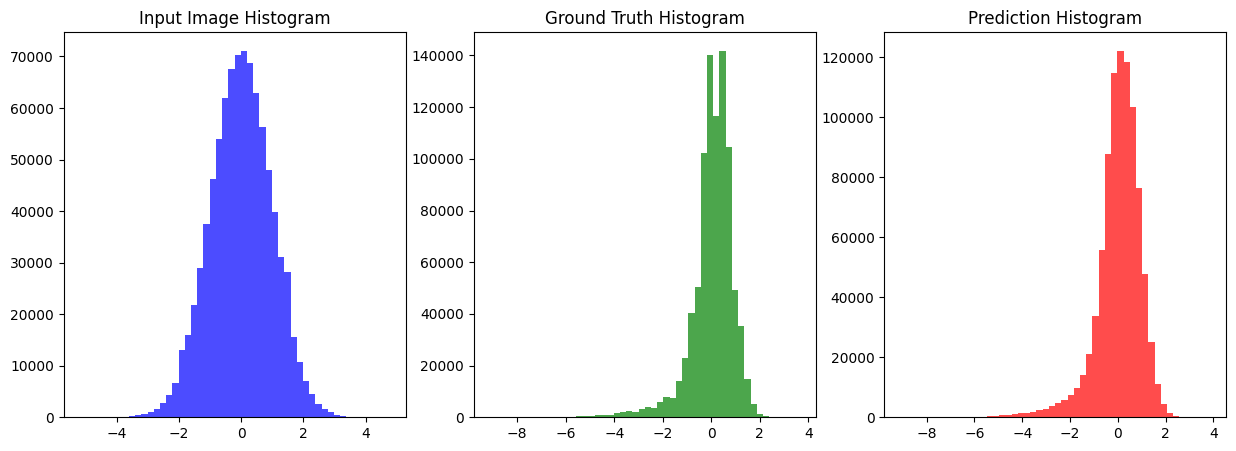

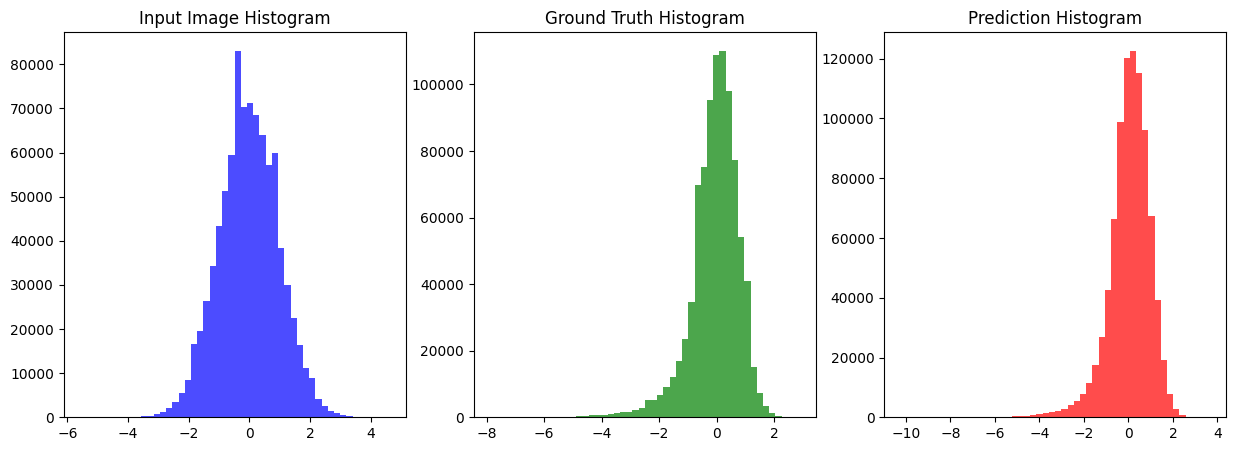

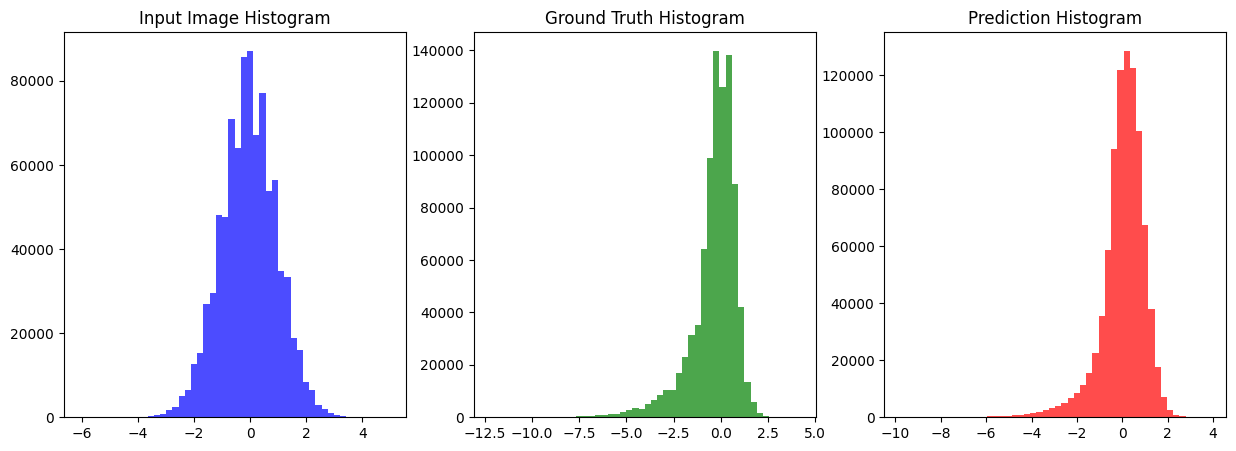

In [9]:
from scipy.stats import wasserstein_distance

def plot_histograms(images, labels, preds, num_images=3):
    for i in range(num_images):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].hist(images[i].flatten(), bins=50, color='blue', alpha=0.7)
        axes[0].set_title('Input Image Histogram')
        
        axes[1].hist(labels[i].flatten(), bins=50, color='green', alpha=0.7)
        axes[1].set_title('Ground Truth Histogram')
        
        axes[2].hist(preds[i].flatten(), bins=50, color='red', alpha=0.7)
        axes[2].set_title('Prediction Histogram')
        
        plt.show()

# 예측 결과와 실제 라벨 시각화 및 히스토그램 시각화
images, labels, preds = get_predictions(model, val_loader, device, num_images=3)
plot_histograms(images, labels, preds, num_images=3)


In [10]:
def calculate_histogram_similarity(images, labels, preds, num_images=3):
    for i in range(num_images):
        image_hist, _ = np.histogram(images[i].flatten(), bins=50, density=True)
        label_hist, _ = np.histogram(labels[i].flatten(), bins=50, density=True)
        pred_hist, _ = np.histogram(preds[i].flatten(), bins=50, density=True)
        
        image_label_similarity = wasserstein_distance(image_hist, label_hist)
        image_pred_similarity = wasserstein_distance(image_hist, pred_hist)
        label_pred_similarity = wasserstein_distance(label_hist, pred_hist)
        
        print(f"Image {i+1} - Image vs Label Similarity: {image_label_similarity:.4f}")
        print(f"Image {i+1} - Label vs Prediction Similarity: {label_pred_similarity:.4f}")

calculate_histogram_similarity(images, labels, preds, num_images=3)

Image 1 - Image vs Label Similarity: 0.0517
Image 1 - Label vs Prediction Similarity: 0.0110
Image 2 - Image vs Label Similarity: 0.0328
Image 2 - Label vs Prediction Similarity: 0.0209
Image 3 - Image vs Label Similarity: 0.0340
Image 3 - Label vs Prediction Similarity: 0.0125


In [ ]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)